# Additional Examples
In the following section more examples for using pytalises will be explored

In [34]:
import pytalises as pt
import numpy as np
from matplotlib import pyplot as plt

## Time-dependent Rabi model
In [Usage and Examples](examples.ipynb) the time-independent Rabi model was already simulated. The independence from $t$ is achieved by going into a rotating frame. 
We will explore this possibility later in other examples. For now, we stick to the regular Schrödinger picture of the Hamiltonian.  
The system comprises of two internal states that differ in their energy by $\hbar\omega$.
An interaction is driven by a time-periodic potential (e.g. electromagnetic wave). The complete potential is

$$
V/\hbar
=
\begin{bmatrix}
0 & \frac{\Omega}{2}\exp (i\omega t) \\
\frac{\Omega}{2}\exp (-i\omega t) & \omega
\end{bmatrix},
$$


where $\Omega$ is the Rabi frequency.  
We generate the wave function and define the Rabi frequency:

In [35]:
psi = pt.Wavefunction(["exp(-x**2)","0"], number_of_grid_points=(256,),
    spatial_ext=(-5,5), normalize_const=1.0)

V = ["0", "Omega_Rabi/2*exp(-1j*omega*t)", "omega"]

f_Rabi = 1
Omega_Rabi = 2*np.pi*f_Rabi
pulse_length = 1/f_Rabi # One complete inversion
num_time_steps = 100
pop = np.zeros((num_time_steps, 2)) # vector that saves the state population
time = np.zeros(num_time_steps)

We simulate the time-propagation for one time unit. Since the Rabi frequency is $2\pi$ we will achieve exactly one inversion.

Text(0.5, 1.0, 'A Rabi cycle')

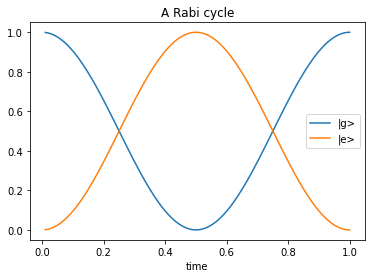

In [36]:
for i in range(num_time_steps):
    psi.propagate(V, num_time_steps=1,
        delta_t=pulse_length/num_time_steps,
        variables={'Omega_Rabi': Omega_Rabi, 'omega': 10})
    pop[i,:] = psi.state_occupation()
    time[i] = psi.t

lines = plt.plot(time, pop)
plt.legend(lines, ('|g>', '|e>'))
plt.xlabel("time")
plt.title("A Rabi cycle")

## Excitation with momentum transfer
One can also achieve excitation with momentum transfer $|p\rangle \leftrightarrow |p+k\rangle$ with periodic potentials with spatial periodicity $k$. Ultimately this is what happens with monochromatic laser light that is $\propto \exp i(kx-\omega t)$.
Let us look a that in a concrete example:


> **Note**: In many examples we set $\hbar=m$. Thus, the Schrödinger equation svoled is $\partial_t \psi = \frac{1}{2}\nabla^2 \psi + \frac{V}{\hbar} \psi$. Furthermore, this implies that in these simulations velocity and wave vector are the same $v = \frac{p}{m} = \frac{\hbar k}{m} = k$. The numeric value for the mass of the simulated particle can be changed with the keyword argument `m` in the `pytalises.Wavefunction` class.

Text(0.5, 1.0, 'Prob. amplitude of wave function')

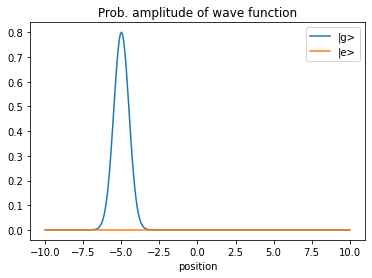

In [37]:
psi = pt.Wavefunction(["exp(-(x+5)**2)","0"], number_of_grid_points=(256,),
    spatial_ext=(-10,10), normalize_const=1.0)

lines = plt.plot(psi.r, np.abs(psi.amp)**2)
plt.legend(lines, ('|g>', '|e>'))
plt.xlabel("position")
plt.title("Prob. amplitude of wave function")

Again, we have a two level system. We will excite the ground state to the excited state but this time the excited state will gain momentum.
The potential for a resonant excitation is


$$
V/\hbar
=
\begin{bmatrix}
0 & \frac{\Omega}{2}\exp i((\omega+\frac{k^2}{2} )t + kx) \\
\frac{\Omega}{2}\exp -i((\omega+\frac{k^2}{2} )t + kx) & \omega
\end{bmatrix}
$$


The frequency $\omega$ has to be adjusted in order to drive a resonant excitation. There are two reasons for this. Firstly, the momentum transfer results in an increase in kinetic energy $\frac{p^2}{2}$. Furthermore, the state with gained velocity $v$ experiences a Doppler shift of the potential that decreases the seen frequency by $-v \cdot k$. in Our case the initial velocity is zero. The frequency has to be adjusted by $\frac{p^2}{2m\hbar} = \frac{k^2}{2} .$  
The pulse will be applied for a quarter the time that it needs for an inversion. In this case we achieve a 50:50 superposition of excited and ground state.

Text(0.5, 1.0, 'Half Rabi cycle')

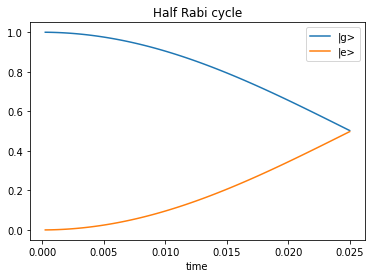

In [38]:
V = ["0", "Omega_Rabi/2*exp(-1j*((omega+k**2/2)*t-k*x))", "omega"]

f_Rabi = 10
Omega_Rabi = 2*np.pi*f_Rabi
pulse_length = 1/f_Rabi/4 # length for 50:50 beamsplitter pulse
num_time_steps = 100
pop = np.zeros((num_time_steps, 2))
time = np.zeros(num_time_steps)

for i in range(num_time_steps):
    psi.propagate(V, num_time_steps=1,
        delta_t=pulse_length/num_time_steps,
        variables={'Omega_Rabi': Omega_Rabi, 'omega': 10, 'k':10})
    pop[i,:] = psi.state_occupation()
    time[i] = psi.t

lines = plt.plot(time, pop)
plt.legend(lines, ('|g>', '|e>'))
plt.xlabel("time")
plt.title("Half Rabi cycle")

Indeed, we achieve an equal superposition. Lets have a look at our wave function in momentum space:

Text(0.5, 1.0, 'Prob. amplitude of wave function')

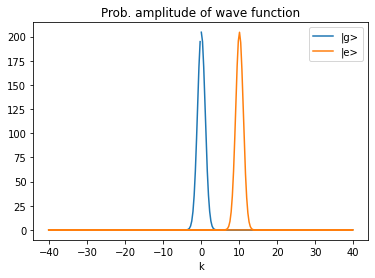

In [39]:
psi.fft()
lines = plt.plot(psi.k, np.abs(psi.amp)**2)
plt.legend(lines, ('|g>', '|e>'))
plt.xlabel("k")
plt.title("Prob. amplitude of wave function")

in momentum space we also have an equal superposition of the states $|p\rangle$ and $|p+k\rangle=|p+10\rangle$.
Of course this can also be seen by looking at the simple free propagation in position space:

Text(0.5, 1.0, 'Prob. amplitude of wave function')

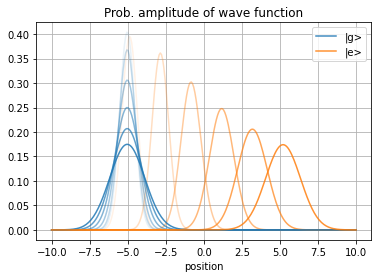

In [40]:
psi.ifft() # transform back into r-space
for i in range(6):
    line1, = plt.plot(psi.r, np.abs(psi.amp[:,0])**2, 'C0-', alpha=.1+i*.15)
    line2, = plt.plot(psi.r, np.abs(psi.amp[:,1])**2, 'C1', alpha=.1+i*.15)
    plt.grid(True)
    psi.freely_propagate(num_time_steps=1, delta_t=0.2)
plt.legend([line1, line2], ('|g>', '|e>'))
plt.xlabel("position")
plt.title("Prob. amplitude of wave function")

## Three-level Raman transitions
In this section we derive the standard three-level Hamiltonian for Raman transitions and simulate the transition.
First we do this with no spatial dependency on the electromagnetic field (and therefore no momentum transfer) and then extend this model to the physically relevant situation of imparting a large momentum via two-photon transition on the wave-packet.  

__Raman transitions with no momentum transfer__  


The general aim of a Raman transition is to transfer probability amplitudes between two states via a third intermediate state.
In this example the three states are $|\omega_g\rangle$, $|\omega_e\rangle$ and $|\omega_i\rangle$. The ground and excited state will be coupled to the intermediate state with monochromatic light of frequencies $\omega_1$ and $\omega_2$, but no direct coupling between the excited and ground state is present.

![Three-level Raman transition with no momentum transfer](_static/three_level.svg)

$\Delta$ is the so called one-photon detuning.
The Hamiltonian can be written as follow:

In [41]:
from sympy import *
x, t = symbols('x t', real=True)
Omega_1, Omega_2 = symbols('\Omega_1 \Omega_2', real=True)
k_1, k_2 = symbols('k_1 k_2', real=True)
omega_1, omega_2 = symbols('\omega_1 \omega_2', real=True)
omega_g, omega_e, omega_i = symbols('\omega_g \omega_e \omega_i', real=True)
hbar = symbols('\hbar', constant=True)

H02 = Omega_1/2*exp(I*(k_1*x-omega_1*t))
H12 = Omega_1/2*exp(I*(k_1*x-omega_2*t))
H = Matrix([
        [omega_g,   0,      conjugate(H02)],
        [0,     omega_e,    conjugate(H12)],
        [H02,   H12,        omega_i]])
H

Matrix([
[                               \omega_g,                                       0, \Omega_1*exp(-I*(-\omega_1*t + k_1*x))/2],
[                                      0,                                \omega_e, \Omega_1*exp(-I*(-\omega_2*t + k_1*x))/2],
[\Omega_1*exp(I*(-\omega_1*t + k_1*x))/2, \Omega_1*exp(I*(-\omega_2*t + k_1*x))/2,                                 \omega_i]])

However, there is one problem in using this Hamiltonian for simulations: the frequency differences between the internal states (e.g. $\omega_i-\omega_g$) for optical transitions are at least in the order of $10^{12}\mathrm{Hz}$. Thus, for simulations with high numerical accuracy, one would need a very short step size in the time domain. In order to relax this we will transform the Hamiltonian into a rotating frame in which the high frequency components will be removed.  
The high frequency components of the wave function in the Schrödinger picture are removed by multiplying it with the transformation matrix $\Psi_I = R\Psi$.
The Hamiltonian describing the same dynamics is then $H_I = R H R^\dagger - i R \dot{R^\dagger}$.
We choose the frequencies of the rotating frame to be

In [42]:
R = Matrix([
    [exp(I*(omega_i-omega_1)*t),  0,                                0],
    [0,                 exp(I*(omega_i-omega_2)*t),                 0],
    [0,                 0,                          exp(I*omega_i*t)]
    ])
R

Matrix([
[exp(I*t*(-\omega_1 + \omega_i)),                               0,                 0],
[                              0, exp(I*t*(-\omega_2 + \omega_i)),                 0],
[                              0,                               0, exp(I*\omega_i*t)]])

$R$ can be somewhat arbitrarily chosen. This choice will yield a Hamiltonian only dependent on $\Delta$.
Let us perform the transformation:

In [43]:
H_I = R*H*conjugate(R) - I*R*conjugate(diff(R,t))
simplify(H_I)

Matrix([
[\omega_1 + \omega_g - \omega_i,                              0, \Omega_1*exp(-I*k_1*x)/2],
[                             0, \omega_2 + \omega_e - \omega_i, \Omega_1*exp(-I*k_1*x)/2],
[       \Omega_1*exp(I*k_1*x)/2,        \Omega_1*exp(I*k_1*x)/2,                        0]])

The time-dependencies on the nondiagonal elements have completely vanished. Looking at the above sketch of the three-level system we see that the diagonal elements are $\omega_1+\omega_g-\omega_o=-\Delta$, $\omega_2+\omega_e-\omega_i=-\Delta$ and $0$.  
This is the potential we will use for the first simulation.


$$
V = 
\begin{bmatrix}
-\Delta & 0 & \frac{\Omega_1}{2} \\
0 &-\Delta & \frac{\Omega_2}{2} \\
\frac{\Omega_1}{2} & \frac{\Omega_2}{2} & 0
\end{bmatrix}
$$


For now we will also neglect the spatial dependencies on $k_1$ and $k_2$. We will look at them in the next example when we simulate the transition with momentum transfer.  
Furthermore we actually use SI units from now on and simulate these Hamiltonian on a real world example: the Rubidium-87 D$_2$-line transitions.
The intermediate state will be one of the 5$^2$P$_{3/2}$ states. The ground and excited states are the 5$^2$S$_{1/2}$ $F=1$ and $F=2$ states.
Data for the atom's energy levels can be found [here](https://steck.us/alkalidata/)

In [44]:
m = 1.4447e-25 # Mass of a Rubidium atom

psi = pt.Wavefunction(["exp(-((x-x0)/(2*sigma_x))**2)","0","0"],
    number_of_grid_points=(128,), spatial_ext=(-10e-6,10e-6),
    normalize_const=1.0, m=m,
    variables={'x0': 0, 'sigma_x': 1e-6})

# List of strings describing the lower triangular part of V
V = ["-Delta", "0", "Omega/2", "-Delta", "Omega/2", "0"]

# omega_i-omega_g: energy difference between F'=3 and F=2 Rubidium-87 D2-lines
omega_ig    = 2*np.pi*384.230484468e12 
# omega_e-omega_g: energy difference betwwen F=2 and F=1 of the 5^2 S_{1/2} manifold
omega_eg    = 2*np.pi*6.8e9
# One-photon detuning of 700 MHz
Delta       = 2*np.pi*700e6

The general Rabi frequency for such two-photon transitions is different from the Rabi frequency of the single-photon transitions. It is $\Omega = \frac{\Omega_1 \Omega_2}{2\Delta}$. We calculate the single-photon Rabi frequencies $\Omega_i$ from the fact that we aim to achieve Rabi cycles of the two-photon transition of length $100\; \mathrm{ms}$.

Text(0.5, 1.0, 'Half Rabi cycle')

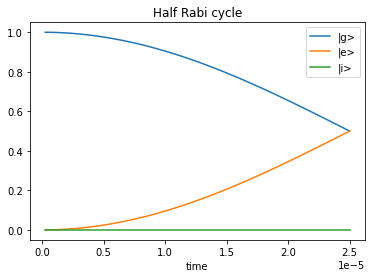

In [45]:
f_Rabi          = 1/100e-6
Omega           = np.sqrt(2*2*np.pi*f_Rabi * Delta)

pulse_length    = 1/f_Rabi/4 # length for beamsplitter
num_time_steps  = 100
pop = np.zeros((num_time_steps, 3))
time = np.zeros(num_time_steps)

for i in range(num_time_steps):
    psi.propagate(V, num_time_steps=1,
        delta_t=pulse_length/num_time_steps,
        variables={'Omega': Omega, 'Delta': Delta})
    pop[i,:] = psi.state_occupation()
    time[i] = psi.t
lines = plt.plot(time, pop)
plt.legend(lines, ('|g>', '|e>', '|i>'))
plt.xlabel("time")
plt.title("Half Rabi cycle")

After $25\;\mathrm{\mu s}$ an equal superposition of ground and excited states is achieved. The intermediate state is only very sparsely populated, but the probability amplitude is indeed transferred via the intermediate state as no nondiagonal elements between ground and excited state exist.  
At last let us have a look on the wave function in position and momentum space:

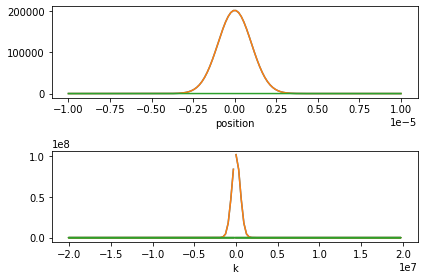

In [46]:
fig, axs = plt.subplots(2,1)
axs[0].plot(psi.r, np.abs(psi.amp)**2)
axs[0].set_xlabel("position")
psi.fft() # Fouriier transform
axs[1].plot(psi.k, np.abs(psi.amp)**2)
axs[1].set_xlabel("k")
plt.tight_layout()

Excited (orange) and ground (blue, but covered by orange) state cover exactly the same position and momentum states.
That is of course boring. In the next calculation we will impart a large momentum on the wave-packet via the two-photon transition.

__Raman transitions with momentum transfer__  


In the previous simulation the wave vectors $k_1$ and $k_2$ of the electromagnetic waves were neglected. In another previous example it was also already shown that the off diagonal potential element $\propto \exp ikx$ leads to a momentum transfer (after all $\exp ikx$ is the position/momentum translation operator).
Stimulated excitation from $|g\rangle\rightarrow |i\rangle$ and emission $|i\rangle\rightarrow |e\rangle$ with light sources $1$ and $2$ give the quantum state an additional momentum of $k_1-k_2$. If $k_1$ and $k_2$ are parallel to each other they do not impart a large momentum, but if anti-parallel they do!  
This calculation differs also from the previous one for the fact that we have to adjust the energy differences of the lasers as the wave-packet acquires kinetic energy $\frac{p^2}{2m}=\frac{\hbar^2(k_1-k_2)}{2m}$ if undergoing the transition. This additional energy difference between the two light sources will be called $\delta$.
The level system is now looking like this:

![Three-level Raman transition](_static/raman_transition.svg)


The resonance condition also includes the term for the Doppler shift $(k_1-k_2)\cdot v$. Here we assume $v=0$.
The Hamiltonian is the one we derived earlier, but now we include the wave vectors $k_i$.  
We can almost completely proceed as done in the case without momentum transfer, only that we have to solve the equation for the resonance condition to obtain a valid $k_2$ (the rest will be assumed as given).

Text(0.5, 1.0, 'One and a half Rabi cycle')

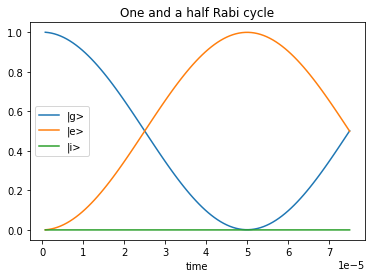

In [47]:
m = 1.4447e-25
hbar = 1.0545718e-34
c = 299792458

psi = pt.Wavefunction(["exp(-((x-x0)/(2*sigma_x))**2)","0","0"],
    number_of_grid_points=(512,), spatial_ext=(-20e-6,20e-6),
    normalize_const=1.0, m=m,
    variables={'x0': 0, 'sigma_x': 3e-6})

V = ["-Delta", "0", "Omega_Rabi/2*exp(1j*k_1*x)", "-(Delta+delta)", "Omega_Rabi/2*exp(1j*k_2*x)", "0"]

omega_ig    = 2*np.pi*384.230484468e12
omega_eg    = 2*np.pi*6.8e9
Delta       = 2*np.pi*700e6
f_Rabi      = 1/100e-6
Omega_Rabi  = np.sqrt(2*2*np.pi*f_Rabi * Delta)
omega_1     = omega_ig-Delta
k_1         = omega_1/c
# solve resonance condition to acquire k_2
from scipy.optimize import root
k_2         = root(lambda k_2: hbar/2/m*(k_1-k_2)**2 - (omega_1 - c*np.abs(k_2)) + omega_eg, -k_1).x
omega_2     = c*np.abs(k_2)
delta    = omega_1-omega_2-omega_eg

pulse_length = 3/f_Rabi/4 # length for 3*pi/2 beamsplitter pulse, just for fun
num_time_steps = 100
pop = np.zeros((num_time_steps, 3))
time = np.zeros(num_time_steps)

for i in range(num_time_steps):
    psi.propagate(V, num_time_steps=1,
        delta_t=pulse_length/num_time_steps,
        variables={'Omega_Rabi': Omega_Rabi, 'c': c,
        'omega_1': omega_1, 'k_1': k_1,
        'omega_2': omega_2, 'k_2': k_2,
        'Delta': Delta, 'delta': delta})
    pop[i,:] = psi.state_occupation()
    time[i] = psi.t
lines = plt.plot(time, pop)
plt.legend(lines, ('|g>', '|e>', '|i>'))
plt.xlabel("time")
plt.title("One and a half Rabi cycle")

Now if we take a look at the wave function ampltidues in $k$-space we will see that they are not only in a superposition of energy states, but also momentum states.

Text(0.5, 1.0, 'Prob. amplitude of wave function')

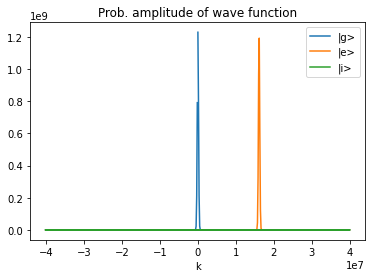

In [48]:
psi.fft()
lines = plt.plot(psi.k, np.abs(psi.amp)**2)
plt.legend(lines, ('|g>', '|e>', '|i>'))
plt.xlabel("k")
plt.title("Prob. amplitude of wave function")

The momentum is

In [49]:
print(k_1-k_2)

[16105579.10347923]


just as expected.  
Let us have a look now how the wave function evolves in position space

Text(0.5, 1.0, 'Prob. amplitude of wave function')

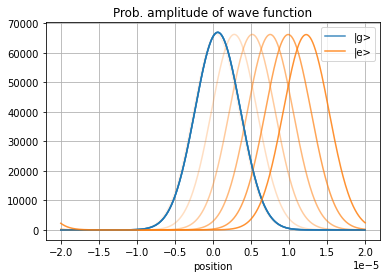

In [50]:
psi.ifft() # transform back into r-space
for i in range(6):
    line1, = plt.plot(psi.r, np.abs(psi.amp[:,0])**2, 'C0-', alpha=.1+i*.15)
    line2, = plt.plot(psi.r, np.abs(psi.amp[:,1])**2, 'C1', alpha=.1+i*.15)
    plt.grid(True)
    psi.freely_propagate(num_time_steps=1, delta_t=2e-4)
plt.legend((line1, line2), ('|g>', '|e>'))
plt.xlabel("position")
plt.title("Prob. amplitude of wave function")

## Single-Bragg diffraction
A very similar case to that of the three-level Raman transition is that of Bragg diffraction. Instead of coupling two different states to achieve a momentum transfer, the Bragg transition just requires a ground state that is coupled to an intermediate state with far detuned lasers.


![level scheme Bragg transition](_static/bragg_transition.svg)


Again, we will derive the Hamiltonian in the rotating frame. The Hamiltonian is a $2\times 2$ matrix with off diagonal elements constituent of the eletro-magnetic field of the two laser sources.

In [51]:
x, t = symbols('x t', real=True)
Omega_1, Omega_2 = symbols('\Omega_1 \Omega_2', real=True)
k_1, k_2 = symbols('k_1 k_2', real=True)
omega_1, omega_2 = symbols('\omega_1 \omega_2', real=True)
omega_g, omega_i = symbols('\omega_g \omega_i', real=True)
hbar = symbols('\hbar', constant=True)

H01 = simplify((Omega_1/2*exp(I*(k_1*x-omega_1*t)) + Omega_2/2*exp(I*(k_2*x-omega_2*t))))

H = Matrix([
        [omega_g,       conjugate(H01)  ],
        [H01,           omega_i         ]])
H

Matrix([
[                                                                         \omega_g, \Omega_1*exp(I*\omega_1*t - I*k_1*x)/2 + \Omega_2*exp(I*\omega_2*t - I*k_2*x)/2],
[\Omega_1*exp(-I*\omega_1*t + I*k_1*x)/2 + \Omega_2*exp(-I*\omega_2*t + I*k_2*x)/2,                                                                        \omega_i]])

Applying the rotating frame yields

In [52]:
R = Matrix([[exp(I*(omega_i-omega_1)*t), 0],
    [0, exp(I*(omega_i+0*omega_2)*t)]])
H_I = R*H*conjugate(R) - I*R*conjugate(diff(R,t))
simplify(H_I)

Matrix([
[                                                                     \omega_1 + \omega_g - \omega_i, (\Omega_1*exp(I*(\omega_1*t - k_1*x)) + \Omega_2*exp(I*(\omega_2*t - k_2*x)))*exp(-I*\omega_1*t)/2],
[(\Omega_1*exp(I*(-\omega_1*t + k_1*x)) + \Omega_2*exp(I*(-\omega_2*t + k_2*x)))*exp(I*\omega_1*t)/2,                                                                                                  0]])

Substituting the definitions from the sketch for $\Delta$ and $\delta$ this gives


$$
H_I
=
\begin{bmatrix}
-\Delta &  \frac{\Omega_1}{2} \exp (i k_1 x) + \frac{\Omega_2}{2} \exp (i (k_2 x+\delta t) \\
\frac{\Omega_1}{2} \exp (-i k_1 x) + \frac{\Omega_2}{2} \exp (-i (k_2 x+\delta t)) & 0
\end{bmatrix}
$$

In [53]:
from scipy.optimize import root
m = 1.4447e-25
hbar = 1.0545718e-34
c = 299792458

psi = pt.Wavefunction(["exp(-((x-x0)/(2*sigma_x))**2)","0"],
    number_of_grid_points=(256,), spatial_ext=(-10e-6,10e-6),
    normalize_const=1.0, m=m,
    variables={'x0': 0, 'sigma_x': 1e-6})

V = ["-Delta", "Omega/2 * (exp(1j*k_1*(x+v*t))+exp(1j*(k_2*(x+v*t)+delta*t)))", "0"]

v = 10
omega_ig    = 2*np.pi*384.230484468e12
Delta       = 2*np.pi*700e6
f_Rabi      = 1/300e-6
Omega       = np.sqrt(2*2*np.pi*f_Rabi * Delta)
omega_1     = omega_ig-Delta
k_1         = omega_1/c
k_2         = root(lambda k_2: hbar/2/m*(k_1-k_2)**2 + (k_1-k_2)*v - (omega_1 - c*np.abs(k_2)) , -k_1).x
omega_2     = c*np.abs(k_2)
delta       = omega_1-omega_2
pulse_length = 1/f_Rabi/4 # length for 50:50 beamsplitter pulse
num_time_steps = 100

The parameters are the same as in the other simulations and based on realistic experiments on Rubidium-87 atoms driving transitions between the D$_2$ lines.  
Let us finally simulate the time evolution:

Text(0.5, 1.0, 'Prob. amplitude of wave function')

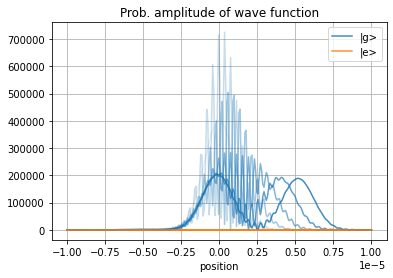

In [54]:
plt.plot(psi.r, np.abs(psi.amp[:,0])**2, 'C0-', alpha=.1)
plt.plot(psi.r, np.abs(psi.amp[:,1])**2, 'C1', alpha=.1)

psi.propagate(V, num_time_steps=num_time_steps,
    delta_t=pulse_length/num_time_steps,
    variables={'Omega': Omega, 'c': c, 'v': v,
    'omega_1': omega_1, 'k_1': k_1,
    'omega_2': omega_2, 'k_2': k_2,
    'Delta': Delta, 'delta': delta})

for i in range(1,6):
    line1, = plt.plot(psi.r, np.abs(psi.amp[:,0])**2, 'C0-', alpha=.1+i*.15)
    line2, = plt.plot(psi.r, np.abs(psi.amp[:,1])**2, 'C1', alpha=.1+i*.15)
    plt.grid(True)
    psi.freely_propagate(num_time_steps=1, delta_t=1e-4)
plt.legend([line1, line2], ('|g>', '|e>'))
plt.xlabel("position")
plt.title("Prob. amplitude of wave function")

As one can see the excited state is almost not populated, but a superposition of momentum states in the ground state is achieved. As the wave-packets separate they shortly interfere.  
Looking at the momentum representation

Text(0.5, 1.0, 'Prob. amplitude of wave function')

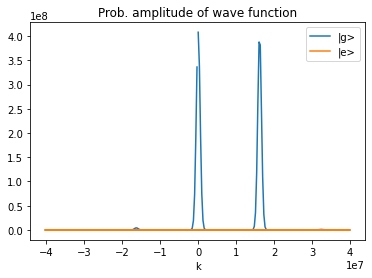

In [55]:
psi.fft()
line = plt.plot(psi.k, np.abs(psi.amp)**2)
plt.legend(line, ('|g>', '|e>'))
plt.xlabel("k")
plt.title("Prob. amplitude of wave function")

one can see that there is also a very small population in the momentum state $-(k_1-k_2)$. This is due to the finite pulse length of the laser pulse. Shorter pulses populate different momentum states even more. Try it out!

## 2D Single-Bragg diffraction with Gaussian beam
Let's make the previous example slightly more realistic with a 2D Gaussian beam.  
The wave function is a 2D Gaussian wave packet

Text(0.5, 1.0, 'Initial wave function density')

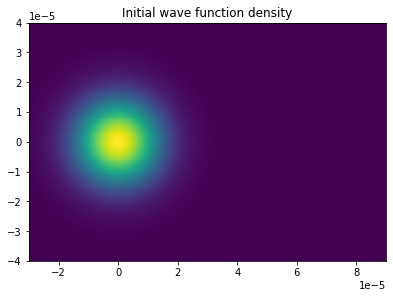

In [56]:
psi = pt.Wavefunction(["exp(-((x-x0)/(2*sigma_x))**2)*exp(-((y-y0)/(2*sigma_y))**2)","0"],
    number_of_grid_points=(2048,256), spatial_ext=[(-30e-6,90e-6),(-40e-6,40e-6)],
    normalize_const=1.0, m=m,
    variables={'x0': 0e-6, 'sigma_x': 10e-6, 'y0': 0e-6, 'sigma_y': 10e-6})

fig = plt.figure(figsize=(6.4, 4.8))
ax = fig.add_subplot()
ax.pcolormesh(psi.r[0], psi.r[1], np.abs(psi.amp[:,:,0].T)**2, rasterized=True)
ax.set_aspect("equal")
ax.set_title("Initial wave function density")

that will be subjected to this more realistic Bragg transition.  
The eletric field amplitudes from the prevous example will be exchanged for that of a Gaussian beam. The other parameter will stay the same.

In [57]:
m = 1.4447e-25
hbar = 1.0545718e-34
c = 299792458

v = 0
omega_ig    = 2*np.pi*384.230484468e12
Delta       = 2*np.pi*700e6
f_Rabi      = 1/400e-6
Omega       = np.sqrt(2*2*np.pi*f_Rabi * Delta)
omega_1     = omega_ig-Delta
k_1         = omega_1/c
k_2         = root(lambda k_2: hbar/2/m*(k_1-k_2)**2 + (k_1-k_2)*v - (omega_1 - c*np.abs(k_2)) , -k_1).x
omega_2     = c*np.abs(k_2)
delta       = omega_1-omega_2
pulse_length = 1/f_Rabi/4 # length for 50:50 beamsplitter pulse
num_time_steps = 10

w0_1        = 7.5e-6 # width of first Gaussian beam
zR_1        = w0_1**2 * k_1 / 2 # Rayleigh range
w0_2        = 7.5e-6 # width of second Gaussian beam
zR_2        = w0_2**2 * k_2 / 2

Amp_gauss_1 = "1/sqrt(1+(x/zR_1)**2) * exp(-(y/(w0_1*sqrt(1+(x/zR_1)**2)))**2 + 1j*(k_1*y**2/(2*x*(1+(zR_1/x)**2)) + k_1*x - arctan(x/zR_1)) )"
Amp_gauss_2 = "1/sqrt(1+(x/zR_2)**2) * exp(-(y/(w0_2*sqrt(1+(x/zR_2)**2)))**2 + 1j*(k_2*y**2/(2*x*(1+(zR_2/x)**2)) + k_2*x - arctan(x/zR_2)) )"

V = ["-Delta", "Omega/2 * ("+Amp_gauss_1+"+"+Amp_gauss_2+"*exp(1j*delta*t) )", "0"]

We take a look at the absolute magnitude of the potential's nondiagonal element:

Text(0.5, 1.0, 'Intensity of interfering Gaussian beams')

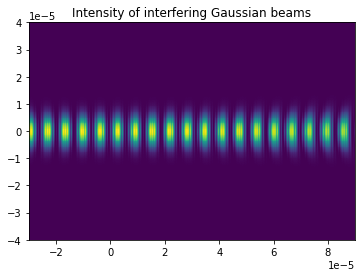

In [58]:
U = pt.Propagator(psi, V, variables={'Omega': Omega, 'c': c, 'v': v,
    'omega_1': omega_1, 'k_1': k_1, 'w0_1': w0_1, 'zR_1': zR_1,
    'omega_2': omega_2, 'k_2': k_2, 'w0_2': w0_2, 'zR_2': zR_2,
    'Delta': Delta, 'delta': delta})
U.eval_V()

fig = plt.figure()
ax = fig.add_subplot()
ax.pcolormesh(psi.r[0], psi.r[1], np.abs(U.V_eval_array[:,:,0,1,0].T)**2, rasterized=True)
ax.set_aspect("equal")
ax.set_title("Intensity of interfering Gaussian beams")

(Note that we used the `pytalises.Propagator` class for this. This class is used in the backend to propagate a `pytalises.Wavefunction` object, but otherwise not used in the examples. You can read more about it in the API.)  
One can clearly see the interference pattern of the two counterpropagating Gaussian beams as well as their curvature. Now let us performed the Bragg pulses and see what happens to the wave function.

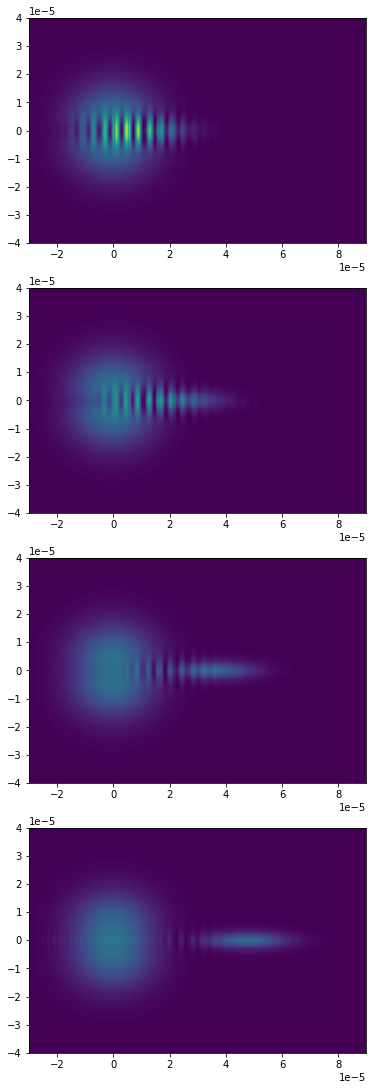

In [59]:
psi.propagate(V, num_time_steps=num_time_steps,
    delta_t=pulse_length/num_time_steps,
    variables={'Omega': Omega, 'c': c, 'v': v,
    'omega_1': omega_1, 'k_1': k_1, 'w0_1': w0_1, 'zR_1': zR_1,
    'omega_2': omega_2, 'k_2': k_2, 'w0_2': w0_2, 'zR_2': zR_2,
    'Delta': Delta, 'delta': delta})

n_plots = 5
vmax = np.max(np.abs(psi.amp[:,:,0].T)**2)
fig = plt.figure(figsize=(6.4, n_plots*4.8))
for i in range(n_plots-1):
    psi.freely_propagate(num_time_steps=1, delta_t=1e-3)
    ax = fig.add_subplot(n_plots,1,i+1, adjustable="box")
    ax.pcolormesh(psi.r[0], psi.r[1], np.abs(psi.amp[:,:,0].T)**2, rasterized=True, vmax=vmax)
    ax.set_aspect("equal")

Since we made the Gaussian beams' waists smaller than the wave function it is only partially subjected to the Bragg transition and a big part of it stays unaffected. However, the inner part experiences the momentum kick.

## Light-pulse atom interferometry with single Bragg diffraction

In this example we simulate the separation and recombination of a wave-packet that has been subjected to laser pulses inducing Bragg diffraction.
In contrast to the previous example of Bragg diffraction that used the physically accurate description of a two-level system, we employ an effective description of a one-level system with a wave-packet scattered by a periodic potential resembling a crystal (hence the connection with Bragg).  
We start with a gaussian wave packet offset by -25 position units and zero moneutm $k=0$.

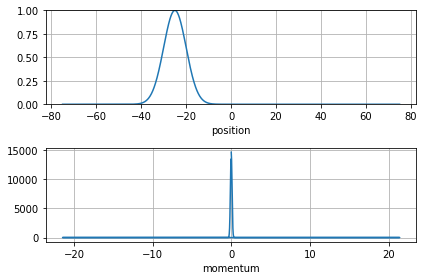

In [60]:
psi = pt.Wavefunction("exp(-((x-x0)/(2*sigmax))**2)", number_of_grid_points=(1024,),
    spatial_ext=(-75,75), variables={'x0': -25, 'sigmax': 5})

def init_plot():
    fig = plt.figure()
    axs = fig.subplots(2,1)
    line1, = axs[0].plot(psi.r, np.abs(psi.amp)**2)
    axs[0].grid()
    axs[0].set_ylim(0,1)
    axs[0].set_xlabel("position")
    psi.fft();
    line2, = axs[1].plot(psi.k, np.abs(psi.amp)**2)
    axs[1].grid()
    axs[1].set_xlabel("momentum")
    psi.ifft();
    fig.tight_layout()
    return fig, axs, line1, line2

fig, axs, line1, line2 = init_plot()

You see the wave function in position and momentum representation. In position space it is ineed offset and in momentum space centered at 0.

We will now perform the first Bragg pulse.
The effective potential is


$$
V(x,t)/\hbar = 2\Omega \cos^2 (k(x-k t)),
$$


with Rabi frequency $\Omega$ and wave vector $k$. This potential drives transitions between the momentum states
$|p\rangle \leftrightarrow |p+2k\rangle$.
In this case we set $k=5$ and $\Omega=2\pi$. A beamsplitter $\pi/2$ pulse is achieved after $t=\frac{\pi/2}{\Omega}$

In [61]:
from matplotlib import animation, rc
from IPython.display import HTML

def animate_bragg_pulse(i):
    psi.propagate("2*Omega*cos(k*(x-k*t))**2", num_time_steps=1,
        delta_t=t_end/num_time_steps, variables={"Omega": 2*np.pi*f_R, "k": 5}, diag=True)
    line1.set_ydata(np.abs(psi.amp)**2)
    psi.fft()
    line2.set_ydata(np.abs(psi.amp)**2)
    psi.ifft()
    return (line1, line2)

fig, axs, line1, line2 = init_plot()

f_R = 2 # Rabi frequency in Hertz
t_end = 1/(4*f_R) # 50:50 beamsplitter
num_time_steps = 100

anim = animation.FuncAnimation(fig, animate_bragg_pulse, frames=num_time_steps, interval=20, blit=True)
plt.close()
HTML(anim.to_html5_video())

As expected the pulse results in an equal superposition of momenutm states $|p\rangle$ and $|p+2k\rangle$.  
In position space we already start to see interference from now two wave packets moving apart.  
The wave function is now freely propagated for 5 time units such that both wave packets are seperated by $k t=50$ position units.

In [62]:
def animate_freeprop(i):
    psi.freely_propagate(num_time_steps=1, delta_t=t_end/num_time_steps)
    line1.set_ydata(np.abs(psi.amp)**2)
    psi.fft()
    line2.set_ydata(np.abs(psi.amp)**2)
    psi.ifft()
    return (line1, line2)

fig, axs, line1, line2 = init_plot()

t_end = 5

anim = animation.FuncAnimation(fig, animate_freeprop, frames=num_time_steps, interval=20, blit=True)
plt.close()
HTML(anim.to_html5_video())

Now we will apply a mirror $\pi$ pulse that will invert the momentum states in order to recombine both wave packets.

In [63]:
fig, axs, line1, line2 = init_plot()

t_end = 1/(2*f_R) # mirror pulse

anim = animation.FuncAnimation(fig, animate_bragg_pulse, frames=num_time_steps, interval=20, blit=True)
plt.close()
HTML(anim.to_html5_video())

Now the right wave packet will be in momentum state $|p\rangle$ and the left in $|p+2k\rangle$. They propagate freely for the same time they were seperating after the first pulse.

In [64]:
fig, axs, line1, line2 = init_plot()

t_end = 5

anim = animation.FuncAnimation(fig, animate_freeprop, frames=num_time_steps, interval=20, blit=True)
plt.close()
HTML(anim.to_html5_video())

Now that they are spatially overlapping we can recombine them with a final beamsplitter pulse.

In [65]:
fig, axs, line1, line2 = init_plot()

t_end = 1/(4*f_R) # 50:50 beamspliter pulse

anim = animation.FuncAnimation(fig, animate_bragg_pulse, frames=num_time_steps, interval=20, blit=True)
plt.close()
HTML(anim.to_html5_video())

Let's have a final look at the wave function

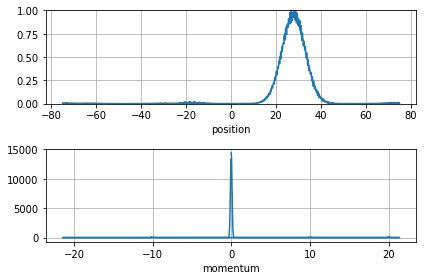

In [66]:
init_plot();

The wave function is, again, completely in its initial momentum state but has travelled the 50 position units. One can also see some interference due to imperfect beamsplitter operations to auxiliary states.